### Import Library


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os

### Set Path Dataset


In [2]:
base_dir = "D:/laskarAI/ml-terrascan/dataset_split"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

img_height = 224
img_width = 224
batch_size = 32

### Load Dataset


In [3]:
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

class_names = train_ds.class_names
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 128 files belonging to 8 classes.
Found 32 files belonging to 8 classes.


### Augmentasi & Preprocessing


In [4]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

preprocess_input = tf.keras.applications.efficientnet.preprocess_input

### Bangun Model


In [5]:
# Membuat base model dengan pre-trained weights dari ImageNet
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

# Fine-tuning pada sebagian layer
base_model.trainable = True

# Membekukan layer-layer yang lebih dalam (misalnya, hanya melatih beberapa layer teratas)
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Membuat arsitektur model dengan layer tambahan
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)  # Melakukan preprocessing pada input
x = base_model(x, training=False)  # Forward pass ke base model
x = layers.GlobalAveragePooling2D()(x)  # Global average pooling
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # L2 Regularization
x = layers.Dropout(0.5)(x)  # Dropout untuk regularisasi
outputs = layers.Dense(num_classes, activation='softmax')(x)  # Output layer

# Model akhir
model = models.Model(inputs, outputs)


### Compile and Train


In [6]:
# Compile model dengan optimizers dan loss function yang sesuai
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Gunakan learning rate rendah untuk fine-tuning
    loss='sparse_categorical_crossentropy',  # Atau bisa 'categorical_crossentropy'
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.1583 - loss: 9.3888 - val_accuracy: 0.2812 - val_loss: 9.2689 - learning_rate: 1.0000e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.2812 - loss: 9.2126 - val_accuracy: 0.3125 - val_loss: 9.1016 - learning_rate: 1.0000e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4208 - loss: 8.9014 - val_accuracy: 0.3750 - val_loss: 8.9474 - learning_rate: 1.0000e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4812 - loss: 8.7993 - val_accuracy: 0.4688 - val_loss: 8.8052 - learning_rate: 1.0000e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6469 - loss: 8.5585 - val_accuracy: 0.5312 - val_loss: 8.6738 - learning_rate: 1.0000e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6271 - loss: 8.4615 - val_accuracy: 0.5000 - val_loss: 8.5540 - learning_rate: 1.0000e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7344 - loss: 8.3137 - val_accura

### Visualisasi Akurasi


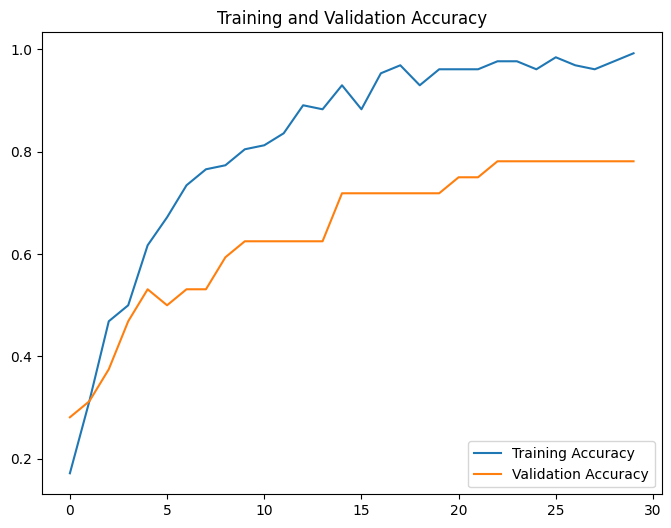

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

### Save Model


In [8]:
model.save("D:/laskarAI/ml-terrascan/model_terrascan.keras")
print("✅ Model saved as model_terrascan.keras")

✅ Model saved as model_terrascan.keras
